# Event-Driven Backtesting Engine

## No look-ahead bias, Realistic execution & Trade-level analytics

---

### Overview

This notebook demonstrates the use of a modular Python framework for **event‑driven backtesting** at tick or bar level.  
The engine is designed to replicate realistic trading execution with:

- **Single‑position simulations** (long/short)  
- **Capital tracking** and wealth computation  
- **Trade‑level analytics** with detailed journaling  
- **Execution at *t+1*** to eliminate look‑ahead bias

The framework is validated with simple EMA and ARIMA strategies — not for performance optimisation, but to **illustrate robustness of the engine**.

---

### Features

- **Event‑Driven Core**
  - Tick‑by‑tick or bar‑by‑bar simulation  
  - Execution at next tick/bar open → no look‑ahead bias  
  - Capital, PnL, and wealth tracking  

- **Trade Analytics**
  - Full trade journaling (side, units, entry/exit, PnL, duration)  
  - Risk metrics: Sharpe, Sortino, Max Drawdown, Gain/Loss ratio  
  - **Kelly Criterion** calculation  

- **Validation Strategies**
  - EMA crossover (trend‑following example)  
  - ARIMA forecast (time‑series example)  
  - Used only to illustrate engine behaviour  

- **Visualisation**
  - Wealth vs Buy & Hold  
  - Cumulative PnL

---

### Utils & FinancialData
These classes are designed to prepare the python files and financial data that will be used to build the desired backtest engine.

- **`utils`**: helper functions and imports for the framework
- **`FinancialData`**: collects and preprocesses raw financial data.

This ensures that all strategies run on **clean, standardised inputs**, making the backtest engine reproducible and extensible.

In [4]:
'''
Utility functions and imports for the framework.
Includes:
- Return conversions (log <-> simple)
- Common imports (numpy, pandas, matplotlib, yfinance, quantstats, etc.)
- ARIMA model and sklearn train/test split
- Warning filters for statsmodels
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import quantstats as qs
import datetime as dt

# --- Helpers ---

def convert_to_simple_returns (df: pd.DataFrame) -> pd.DataFrame :
    df['simple_returns'] = np.exp(df['log_returns']) -1
    return df
    
def convert_to_log_returns (df: pd.DataFrame) -> pd.DataFrame :
    df['log_returns'] = np.log(df['simple_returns'] +1)
    return df

# --- If ARIMA / ARCH / GARCH ---
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message='.*No supported index is available.*')
warnings.filterwarnings('ignore', message='.*no associated frequency information.*')
warnings.filterwarnings('ignore', message='Non-stationary starting autoregressive parameters')
warnings.filterwarnings('ignore', message='No frequency information was provided')

In [5]:
class FinancialData () :
    # Class to enable (1) data downloading via Yahoo Finance AND (2) clean the data
    
    def __init__ (self, ticker, end_date, days_nbr, interval) :
        self.ticker = ticker
        self.days_nbr = days_nbr
        self.end_date = end_date
        self.interval = interval
        self.data = self.get_data(self.ticker, self.end_date, self.interval)
        self.data = self.add_log_returns (self.data)

    def get_data (self, ticker, end_date, interval) : # Dowload and clean the raw data from yahoo finance
        # Download :
        start_date = self.get_start_date (self.end_date, self.days_nbr)
        raw_df = yf.download(ticker, start = start_date, end = end_date, interval = interval, auto_adjust = True)
        # Clean :
        if isinstance(raw_df.columns, pd.MultiIndex) :
            raw_df.columns = raw_df.columns.droplevel(1)
        # Organize
        clean_df = raw_df[['Open', 'High', 'Low', 'Close', 'Volume']]
        return clean_df

    def get_start_date (self, end_date, days_nbr) : # Return the start date with two parameter : end_date, duration
        duration = dt.timedelta(days=days_nbr)
        return end_date - duration

    def add_log_returns (self, clean_df) : # Create the log return columns and fill it
        clean_df ['log_returns'] = np.log(clean_df ['Close'] / clean_df ['Close'].shift(1))
        # Drop the NaN raw to avoid computation issues later
        clean_df.dropna(inplace=True)
        return clean_df

---

### EventBased Class

The `EventBased` class provides the **core backtesting engine** for event‑driven simulations.  
Its primary goals are to **eliminate look‑ahead bias** and to ensure **realistic trade execution** by enforcing signal generation at *t* and execution at *t+1*.

#### Key Points
- Inherits from `FinancialData` to access preprocessed OHLCV data  
- Runs a tick‑ or bar‑level simulation loop  
- Executes trades at the next tick/bar open → no look‑ahead bias  
- Tracks capital, PnL, and overall wealth throughout the simulation  
- Manages a single open position at a time (long or short) with entry/exit logic  
- Journals every trade: side, units, entry/exit date & price, PnL, duration  
- Stores performance metrics for later analysis  

In [6]:
class EventBased (FinancialData) :
    '''
    EventBased class for event‑driven backtesting of trading strategies.
    '''
    
    def __init__ (self, ticker: str, end_date: dt.date, days_nbr: int, interval: str, amount: float, allow_negative_balance: bool) :
        super().__init__(ticker, end_date, days_nbr, interval) # Allows us to directly create and use FinancialData's object by creating a EventBase's object
        self.initial_balance = amount
        self.current_balance = amount
        self.allow_negative_balance = allow_negative_balance
        self.position = {
            'side': None,  # 'long' or 'short'
            'units': 0,
            'entry_date': None,
            'entry_price': None
            }
        self.buy_trades = 0 # Distinction between the differentes trade in order to quickly know the % of each that are made
        self.sell_trades = 0
        self.close_trades = 0 # Compute it cause (buy + sell + close) * trade costs = total of costs for trading
        self.trade_performance = {} # Empty dictionnary that will store the performance per trade

    def get_date_price (self, ind_nbr) :
        # Function to get the date and the price at this date
        date = self.data.index[ind_nbr]
        price = self.data['Close'].iloc[ind_nbr]
        return date, price

    def get_execution_price(self, ind_nbr):
        # Function used to avoid look ahead bias by taking position at the next period
        exec_date = self.data.index[ind_nbr + 1]
        exec_price = self.data['Open'].iloc[ind_nbr + 1]
        return exec_date, exec_price

    def print_balance (self, ind_nbr) :
        # Function to print the current balance
        date, price = self.get_date_price (ind_nbr)
        print(f'Date : {str(date)} | Account Current Balance : {self.current_balance}')

    def print_wealth (self, ind_nbr) :
        # Compute and print the total wealth = Available cashflow + Open positions
        date, price = self.get_date_price (ind_nbr)
        total_wealth = self.current_balance + self.position['units'] * price
        print(f'Date : {str(date)} | Total Wealth : {total_wealth:.2f}')

    def enter_long (self, ind_nbr, units=None, amount=None) :
        date, price = self.get_execution_price (ind_nbr)
        base_amount = amount if amount is not None else self.current_balance
        if not self.allow_negative_balance and base_amount < price:
            print(f'[{date}] Not enought capital to enter long')
            return
        if units is None:
            units = max(int(abs(base_amount) / price), 1)
        self.current_balance -= units * price
        self.position['side'] = 'long'
        self.position['units'] = units
        self.position['entry_date'] = date
        self.position['entry_price'] = price
        self.buy_trades += 1
        print(f'Date : {date} | ORDER = Long : {units} shares at {price}€')
        self.print_balance (ind_nbr)
        self.print_wealth (ind_nbr)

    def enter_short (self, ind_nbr, units=None, amount=None) :
        date, price = self.get_execution_price (ind_nbr)
        base_amount = amount if amount is not None else self.current_balance
        if not self.allow_negative_balance and base_amount < price:
            print(f'[{date}] Not enought capital to enter short')
            return
        if units is None:
            units = max(int(abs(base_amount) / price), 1)
        self.current_balance += units * price
        self.position['side'] = 'short'
        self.position['units'] = units
        self.position['entry_date'] = date
        self.position['entry_price'] = price
        self.sell_trades += 1
        print(f'Date : {str(date)} | ORDER = Short : {units} shares at {price}€')
        self.print_balance (ind_nbr)
        self.print_wealth (ind_nbr)
    
    def close_position (self, ind_nbr) :
        date, price = self.get_execution_price (ind_nbr)
        self.closing_date = date
        self.closing_price = price
        units = self.position['units']
        entry_price = self.position['entry_price']
        if self.position['side'] == 'long':
            pnl = units * (self.closing_price - entry_price)
            self.current_balance += pnl
            trade_performance = np.log(self.closing_price / entry_price)
            direction = 'long'
        elif self.position['side'] == 'short':
            pnl = units * (entry_price - self.closing_price)
            self.current_balance += pnl
            trade_performance = np.log(entry_price / self.closing_price)
            direction = 'short'
        else:
            raise ValueError('No Open Positions')
        self.close_trades += 1
        duration = self.closing_date - self.position['entry_date']
        print(f'Date : {str(date)} | Close Position : {units} shares at {self.closing_price}€') # Print the closing trade order
        print(f'Perfomance : {trade_performance * 100 :.2f} % | PnL : {pnl:.2f}€ | Capital : {self.current_balance:.2f}€') # Print the trade performance
        # Save every trade performance and details in a dictionnary to help the metrics computing
        self.trade_performance.update({date : {'Type of trade': direction, 
                                               'Number of shares': units, 
                                               'Duration': duration, 
                                               'Performance [%]': trade_performance *100, 
                                               'Log Return': trade_performance,
                                               'PnL': pnl,
                                               'Capital After Trade': self.current_balance}})
        self.position = {'side': None, 'units': 0, 'entry_date': None, 'entry_price': None} # Reset position

---

### TradeAnalysis Class

The `TradeAnalysis` class provides **post‑trade analytics and reporting** for strategies executed with the event‑driven engine.  
Its purpose is to transform raw trade logs into **desk‑ready performance metrics** and **visualisations**.

#### Key Points
- Converts raw trade dictionary into a structured DataFrame  
- Applies **transaction costs** and **slippage** adjustments  
- Computes basic trade statistics (number of longs/shorts, average duration, average profit, net PnL)  
- Evaluates **risk metrics**: Sharpe ratio, Sortino ratio, Max Drawdown, Gain/Loss ratio  
- Calculates the **Kelly Criterion**
- Generates a **comprehensive strategy report** with all key metrics  
- Provides **visualisations**:  
  - Wealth vs Buy & Hold  
  - Cumulative PnL

> **Note:** Max Drawdown is calculated only on end‑of‑trade equity.  
> Intra‑trade drawdowns are not captured in the current implementation.

In [15]:
class TradeAnalysis():
    '''
    EventBased class for post‑trade analytics and reporting.
    '''

    def __init__(self, trade_performance: dict, capital: int, cost_per_trade: float, slippage: float, price_series: pd.Series):
        if isinstance(trade_performance, pd.DataFrame):
            self.trade_performance = trade_performance.copy()
        else:
            self.trade_performance = pd.DataFrame.from_dict(trade_performance, orient='index')
        self.capital = capital
        self.cost_per_trade = cost_per_trade
        self.slippage = slippage
        self.price_series = price_series

    def _prepare_df(self) -> pd.DataFrame:
        # Creation of a df for all the methods of this class
        df = self.trade_performance.copy()
        if 'Log Return' in df.columns:
            df = df.rename(columns={'Log Return': 'log_returns'})
            df = convert_to_simple_returns(df)
        # Slippage
        if self.slippage != 0:
            df['simple_returns'] -= self.slippage
        # Cost per trade
        if self.cost_per_trade != 0:
            df['simple_returns'] -= self.cost_per_trade / self.capital
        # Net log return
        if 'simple_returns' in df.columns:
            df['Net Log Return'] = np.log(1 + df['simple_returns'])
        return df

    def df_analysis(self) -> pd.Series:
        # Basic trade stats
        df = self._prepare_df()
        nbr_long = (df['Type of trade'] == 'long').sum()
        nbr_short = (df['Type of trade'] == 'short').sum()
        total_trade = len(df)
        avg_period_trade = df['Duration'].mean()
        avg_profit = df['Performance [%]'].mean()
        avg_net_profit = df['PnL'].mean() if 'PnL' in df.columns else 0
        pnl = df['Capital After Trade'].iloc[-1] - self.capital if total_trade > 0 and 'Capital After Trade' in df.columns else 0.0
        summary = {
            'nbr_long': nbr_long,
            'nbr_short': nbr_short,
            'total_trade': total_trade,
            'avg_period_trade': avg_period_trade,
            'avg_profit': avg_profit,
            'avg_net_profit': avg_net_profit,
            'pnl': pnl
        }
        return pd.Series(summary)

    def max_drawdown(self) -> tuple:
        # Max drawdown and recovery time
        df = self.trade_performance.copy()
        if 'Capital After Trade' not in df.columns:
            return 0.0, pd.NaT

        df['equity'] = df['Capital After Trade']
        df['cummax'] = df['equity'].cummax()
        df['drawdown'] = (df['equity'] / df['cummax']) - 1
        df['drawdown'] = df['drawdown'].clip(lower=-1.0)

        max_dd = df['drawdown'].min()

        recovery = pd.NaT
        if max_dd < 0:
            trough = df['drawdown'].idxmin()
            peak_idx = df.loc[:trough, 'equity'].idxmax()
            after = df.loc[trough:]
            if not after.empty:
                recov_idx = after[after['equity'] >= df.loc[peak_idx, 'equity']].index.min()
                if pd.notna(recov_idx):
                    recovery = recov_idx - peak_idx

        return max_dd, recovery

    def sharpe_ratio(self, risk_free: float) -> float:
        # Sharpe based on PnL normalized by initial capital
        df = self.trade_performance.copy()
        if 'PnL' not in df.columns:
            return 0.0
        df['return_on_initial'] = df['PnL'] / self.capital
        excess_returns = df['return_on_initial'] - (risk_free / 252)
        return np.sqrt(252) * excess_returns.mean() / excess_returns.std(ddof=1) if excess_returns.std(ddof=1) != 0 else 0.0

    def sortino_ratio(self, risk_free: float) -> float:
        # Sortino ratio: penalize only downside volatility
        df = self.trade_performance.copy()
        if 'PnL' not in df.columns:
            return 0.0
        df['return_on_initial'] = df['PnL'] / self.capital
        excess_returns = df['return_on_initial'] - (risk_free / 252)
        downside = excess_returns[excess_returns < 0]
        denom = downside.std(ddof=1)
        return np.sqrt(252) * excess_returns.mean() / denom if denom != 0 else 0.0

    def gain_loss_stats(self) -> dict:
        # % winners, gain/loss ratio
        df = self.trade_performance.copy()
        if 'PnL' not in df.columns:
            return {'win_rate': 0, 'gain_loss_ratio': 0}
        wins = df[df['PnL'] > 0]['PnL']
        losses = df[df['PnL'] <= 0]['PnL']
        win_rate = len(wins) / len(df) if len(df) > 0 else 0
        avg_win = wins.mean() if len(wins) > 0 else 0
        avg_loss = abs(losses.mean()) if len(losses) > 0 else 1
        gain_loss_ratio = avg_win / avg_loss if avg_loss != 0 else 0
        return {'win_rate': win_rate, 'gain_loss_ratio': gain_loss_ratio}

    def kelly_criterion(self) -> float:
        # Kelly based on real PnL
        df = self.trade_performance.copy()
        if 'PnL' not in df.columns:
            return 0.0
        wins = df[df['PnL'] > 0]['PnL']
        losses = df[df['PnL'] <= 0]['PnL']
        if len(wins) == 0 or len(losses) == 0:
            return 0.0
        p = len(wins) / len(df)
        q = 1 - p
        avg_win = wins.mean()
        avg_loss = abs(losses.mean())
        R = avg_win / avg_loss
        kelly_fraction = p - (q / R)
        return max(kelly_fraction, 0.0)

    def report(self, risk_free: float = 0.02):
        # Report all metrics
        summary = self.df_analysis()
        sharpe = self.sharpe_ratio(risk_free)
        sortino = self.sortino_ratio(risk_free)
        max_dd, recovery = self.max_drawdown()
        gl_stats = self.gain_loss_stats()
        kelly = self.kelly_criterion()
        print('=== Strategy Report ===')
        print(summary)
        print(f"\nSharpe Ratio (corrected): {sharpe:.2f}")
        print(f"Sortino Ratio: {sortino:.2f}")
        print(f"Max Drawdown: {max_dd:.2%}")
        print(f"Recovery Time: {recovery}")
        print(f"Win Rate: {gl_stats['win_rate']:.2%}")
        print(f"Gain/Loss Ratio: {gl_stats['gain_loss_ratio']:.2f}")
        print(f"Kelly Fraction: {kelly:.2f}")

    def plot_performance(self):
        # Plot Buy & Hold, cumulative PnL and Global Wealth from trade_performance
        if self.trade_performance.empty:
            raise ValueError('trade_performance is empty.')
        df = self.trade_performance.copy()

        # Check required columns
        required_cols = {'PnL', 'Capital After Trade'}
        if not required_cols.issubset(df.columns):
            raise ValueError(f"Missing columns in trade_performance : {required_cols - set(df.columns)}")

        # Sort by index (dates) to rebuild the timeline
        df = df.sort_index()

        # Rebuild wealth series and cumulative PnL
        wealth_series = df['Capital After Trade']
        pnl_series = df['PnL'].cumsum()

        # Buy & Hold series : based on price_series
        bh_series = self.capital * (self.price_series / self.price_series.iloc[0])

        # Plot curves
        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Capital / Wealth')
        wealth_series.plot(ax=ax1, color='blue', label='Global Wealth')
        bh_series.plot(ax=ax1, color='orange', linestyle='--', label='Buy & Hold')

        # Secondary axis for cumulative PnL
        ax2 = ax1.twinx()
        ax2.set_ylabel('Cumulative PnL')
        pnl_series.plot(ax=ax2, color='green', label='Cumulative PnL')

        # Final formatting
        fig.tight_layout()
        plt.title('Performance: Buy & Hold vs Strategy')
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        plt.grid(True)
        plt.show()

---

### EmaCrossStrategy & ArimaTickStrategy

The `EmaCrossStrategy` and `ArimaTickStrategy` classes are designed to **validate the event‑driven backtesting engine** using simple, illustrative strategies.  
Their purpose is not performance optimisation, but to **demonstrate the robustness of the framework** — in particular, its ability to avoid look‑ahead bias and enforce realistic execution.

#### Key Points
- Provide minimal yet representative strategies to test the engine’s execution logic  
- Showcase event‑driven behaviour: signals generated at *t*, executed at *t+1*  
- Each class includes a main‑like script to illustrate trade execution and post‑trade analysis  
- Serve as validation tools for the engine’s capital tracking, journaling, and analytics pipeline  

---

#### EMA Strategy

The `EmaCrossStrategy` class validates the engine using a simple **moving average crossover** approach.  
It is not designed for performance optimisation, but to **illustrate robustness of the event‑driven execution**.

**Signals**
- Enter long when `EMA_short` > `EMA_long`  
- Enter short when `EMA_short` < `EMA_long`  
- Close the current position before opening a new one on crossover  
- Final position is closed at the end of the backtest  

**Key Design**
- Computes two exponential moving averages (short and long window) on closing prices  
- Generates signals based on crossovers between the two EMAs  
- Executes orders at the next tick/bar open via the engine’s `get_execution_price`
- Demonstrates the engine’s ability to handle **position management, capital tracking, and trade journaling**  


In [8]:
class EmaCrossStrategy(EventBased):

    def __init__(self, ticker, end_date, days_nbr, interval, amount,
                 short_window=20, long_window=50, allow_negative_balance: bool = True):
        super().__init__(ticker, end_date, days_nbr, interval, amount, allow_negative_balance)
        self.short_window = short_window
        self.long_window = long_window
        self.data['ema_short'] = self.data['Close'].ewm(span=short_window, adjust=False).mean()
        self.data['ema_long'] = self.data['Close'].ewm(span=long_window, adjust=False).mean()

    def run_backtest(self):
        '''
        - long: ema_short > ema_long
        - short: ema_short < ema_long
        '''
        for i in range(len(self.data) - 1):  # -1 because get_execution_price(i+1)
            if self.data['ema_short'].iloc[i] > self.data['ema_long'].iloc[i]:
                # Entrer long
                if self.position['side'] == 'short':
                    self.close_position(i)
                if self.position['side'] is None:
                    self.enter_long(i, amount=self.current_balance)

            elif self.data['ema_short'].iloc[i] < self.data['ema_long'].iloc[i]:
                # Entrer short
                if self.position['side'] == 'long':
                    self.close_position(i)
                if self.position['side'] is None:
                    self.enter_short(i, amount=self.current_balance)

        # Close last position
        if self.position['side'] is not None:
            self.close_position(len(self.data) - 2)

---

#### Test & Visualisation

[*********************100%***********************]  1 of 1 completed

Date : 2023-10-05 00:00:00 | ORDER = Long : 58 shares at 172.10423261632292€
Date : 2023-10-04 00:00:00 | Account Current Balance : 17.954508253271342
Date : 2023-10-04 00:00:00 | Total Wealth : 9992.53
Date : 2023-10-30 00:00:00 | Close Position : 58 shares at 167.38051344932887€
Perfomance : -2.78 % | PnL : -273.98€ | Capital : -256.02€
Date : 2023-10-30 00:00:00 | ORDER = Short : 1 shares at 167.38051344932887€
Date : 2023-10-27 00:00:00 | Account Current Balance : -88.64068998305436
Date : 2023-10-27 00:00:00 | Total Wealth : 77.95
Date : 2023-11-06 00:00:00 | Close Position : 1 shares at 174.66913933099835€
Perfomance : -4.26 % | PnL : -7.29€ | Capital : -95.93€
Date : 2023-11-06 00:00:00 | ORDER = Long : 1 shares at 174.66913933099835€
Date : 2023-11-03 00:00:00 | Account Current Balance : -270.5984551957222
Date : 2023-11-03 00:00:00 | Total Wealth : -95.66
Date : 2024-02-16 00:00:00 | Close Position : 1 shares at 182.1122335213933€
Perfomance : 4.17 % | PnL : 7.44€ | Capital : 

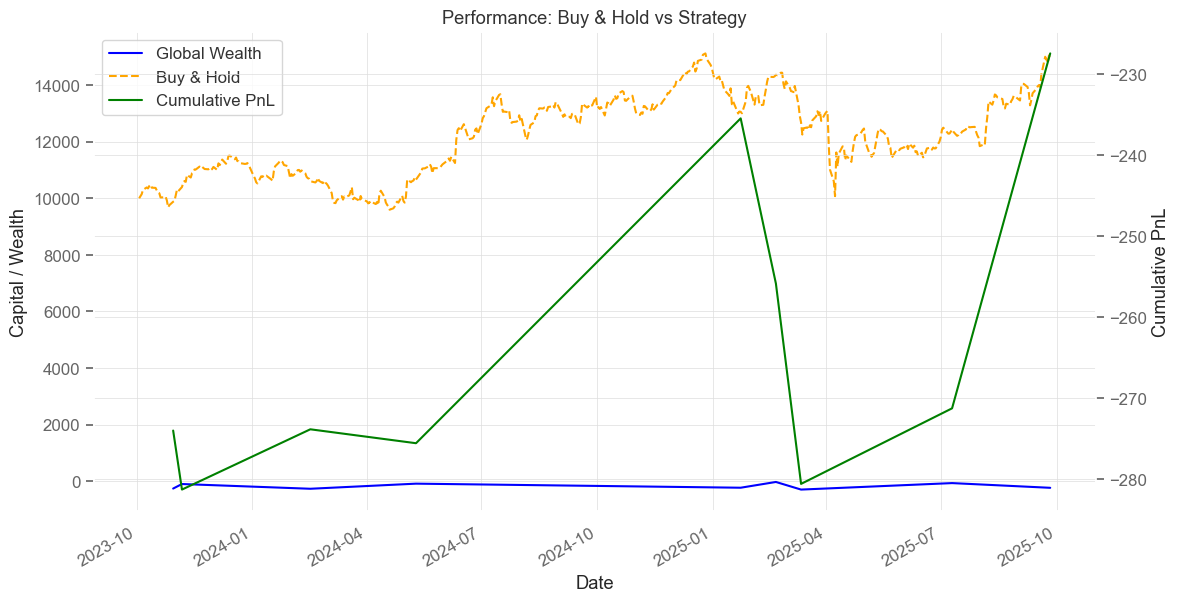

In [13]:
# === Parameters ===
ticker = 'AAPL'
end_date = dt.date.today()
days_nbr = 365 * 2
interval = '1d'
initial_capital = 10000

# === Run and backtest ===
strategy = EmaCrossStrategy(
    ticker=ticker,
    end_date=end_date,
    days_nbr=days_nbr,
    interval=interval,
    amount=initial_capital,
    short_window=20,
    long_window=50,
    allow_negative_balance=True
)

strategy.run_backtest() 

# === Analysis and Visualisation ===
ta = TradeAnalysis(
    trade_performance=strategy.trade_performance,
    price_series=strategy.data['Close'],
    capital=initial_capital,
    cost_per_trade=0,
    slippage=0
)

ta.report()
ta.plot_performance()

---

#### ARIMA Strategy

The `ArimaTickStrategy` class validates the engine using a simple **time‑series forecasting approach**.  
It is not designed for performance optimisation, but to **illustrate robustness of the event‑driven execution**.

**Signals**
- Enter long when forecast ≥ `long_threshold`  
- Enter short when forecast ≤ `-short_threshold`  
- Optional hold zone between [`-short_threshold`, `long_threshold`]  
- Close (and potentially reverse) on strong opposite signal  

**Key Design**
- Fits an **ARIMA(p, d, q)** model over a rolling window of close‑to‑close log returns  
- Re‑fits every `refit_every` ticks to reduce computational load  
- Executes orders at the next tick/bar open via the engine’s `get_execution_price` → ensures no look‑ahead bias  

In [10]:
class ArimaTickStrategy(EventBased):
    
    def __init__(
        self,
        ticker,
        end_date,
        days_nbr,
        interval,
        amount,
        allow_negative_balance: bool = True,
        arima_order=(1, 0, 0),
        window=200,
        refit_every=10,
        long_threshold=0.0005, # ~5 bps
        short_threshold=0.0005, # ~5 bps
        alpha=0.2, # confidence interval level for diagnostics
        max_position_fraction=1.0 # fraction of capital to deploy (1.0 = all-in)
    ):
        super().__init__(ticker, end_date, days_nbr, interval, amount, allow_negative_balance)
        self.p, self.d, self.q = arima_order
        self.window = int(window)
        self.refit_every = int(refit_every)
        self.long_threshold = float(long_threshold)
        self.short_threshold = float(short_threshold)
        self.alpha = float(alpha)
        self.max_position_fraction = float(max_position_fraction)
        self.data['log_ret'] = np.log(self.data['Close']).diff()
        self.data['log_ret'] = (
            self.data['log_ret']
            .replace([np.inf, -np.inf], np.nan)
            .fillna(0.0)
        )
        self._model = None
        self._last_fit_index = None

    def _fit_model(self, end_idx):
        '''
        Fit ARIMA on rolling window up to end_idx (inclusive)
        Returns fitted model and forecast diagnostics
        '''
        start_idx = max(0, end_idx - self.window + 1)
        y = self.data['log_ret'].iloc[start_idx:end_idx + 1].astype(float)

        # Guard against degenerate windows
        if len(y) < max(5, self.p + self.q + 1):
            return None, None, None

        try:
            model = ARIMA(y, order=(self.p, self.d, self.q))
            res = model.fit(method_kwargs={'warn_convergence': False})
        except Exception as e:
            # If ARIMA fails
            print(f'[WARN] ARIMA fit error at idx {end_idx}: {e}')
            return None, None, None

        # One-step-ahead forecast
        fcast = res.get_forecast(steps=1)
        mean = float(fcast.predicted_mean.iloc[0])
        ci = fcast.conf_int(alpha=self.alpha)
        lower = float(ci.iloc[0, 0])
        upper = float(ci.iloc[0, 1])

        self._model = res
        self._last_fit_index = end_idx
        return mean, lower, upper

    def _maybe_refit(self, idx):
        '''
        Refit per schedule
        '''
        should_refit = (self._model is None) or (self._last_fit_index is None) or ((idx - self._last_fit_index) >= self.refit_every)
        if should_refit:
            return self._fit_model(idx)
        else:
            # Still recompute forecast with the same approach to keep API consistent
            return self._fit_model(idx)

    def _position_units(self, price):
        deploy_amount = self.current_balance * self.max_position_fraction
        units = max(int(abs(deploy_amount) / price), 1)
        return units

    def run_backtest(self):
        '''
        Build rolling ARIMA forecast of next-tick return.
        '''
        n = len(self.data)
        # Ensure we have at least one future tick for execution
        if n < 3:
            print('[INFO] Not enough data for tick-by-tick backtest.')
            return

        # Start after we have enough window history and still have one tick ahead to execute
        start_i = max(self.window, 2)
        for i in range(start_i, n - 1):  # -1 to allow execution at i+1
            # Fit/refit model and get forecast for next tick return
            forecast, lower, upper = self._maybe_refit(i)
            if forecast is None:
                # No signal 
                continue
            dt_i, px_i = self.get_date_price(i)
            
            # Decision logic
            go_long = forecast >= self.long_threshold
            go_short = forecast <= -self.short_threshold
            neutral = (not go_long) and (not go_short)

            # Close on neutral if you want flat bias; or keep running position until opposite signal
            if neutral:
                # Optional flattening: close if position exists and forecast lacks conviction
                if self.position['side'] is not None:
                    self.close_position(i)
                continue

            # If signal is long
            if go_long:
                if self.position['side'] == 'short':
                    self.close_position(i)
                if self.position['side'] is None:
                    # Use next tick's open and deploy fraction of capital
                    exec_date, exec_price = self.get_execution_price(i)
                    units = self._position_units(exec_price)
                    self.enter_long(i, units=units)

            # If signal is short
            elif go_short:
                if self.position['side'] == 'long':
                    self.close_position(i)
                if self.position['side'] is None:
                    exec_date, exec_price = self.get_execution_price(i)
                    units = self._position_units(exec_price)
                    self.enter_short(i, units=units)

        # Close any remaining open position at the last executable tick
        if self.position['side'] is not None:
            self.close_position(n - 2)

---

#### Test & Visualisation

[*********************100%***********************]  1 of 1 completed


Date : 2025-02-21 00:00:00 | ORDER = Long : 20 shares at 245.34944139409683€
Date : 2025-02-20 00:00:00 | Account Current Balance : 5093.011172118064
Date : 2025-02-20 00:00:00 | Total Wealth : 9997.61
Date : 2025-02-27 00:00:00 | Close Position : 20 shares at 238.82541422357912€
Perfomance : -2.70 % | PnL : -130.48€ | Capital : 4962.53€
Date : 2025-02-27 00:00:00 | ORDER = Short : 10 shares at 238.82541422357912€
Date : 2025-02-26 00:00:00 | Account Current Balance : 7350.784770943501
Date : 2025-02-26 00:00:00 | Total Wealth : 9748.52
Date : 2025-03-03 00:00:00 | Close Position : 10 shares at 241.19958958341564€
Perfomance : -0.99 % | PnL : -23.74€ | Capital : 7327.04€
Date : 2025-03-03 00:00:00 | ORDER = Long : 15 shares at 241.19958958341564€
Date : 2025-02-28 00:00:00 | Account Current Balance : 3709.0491735939013
Date : 2025-02-28 00:00:00 | Total Wealth : 7327.79
Date : 2025-03-05 00:00:00 | Close Position : 15 shares at 234.84515699420854€
Perfomance : -2.67 % | PnL : -95.32€ |

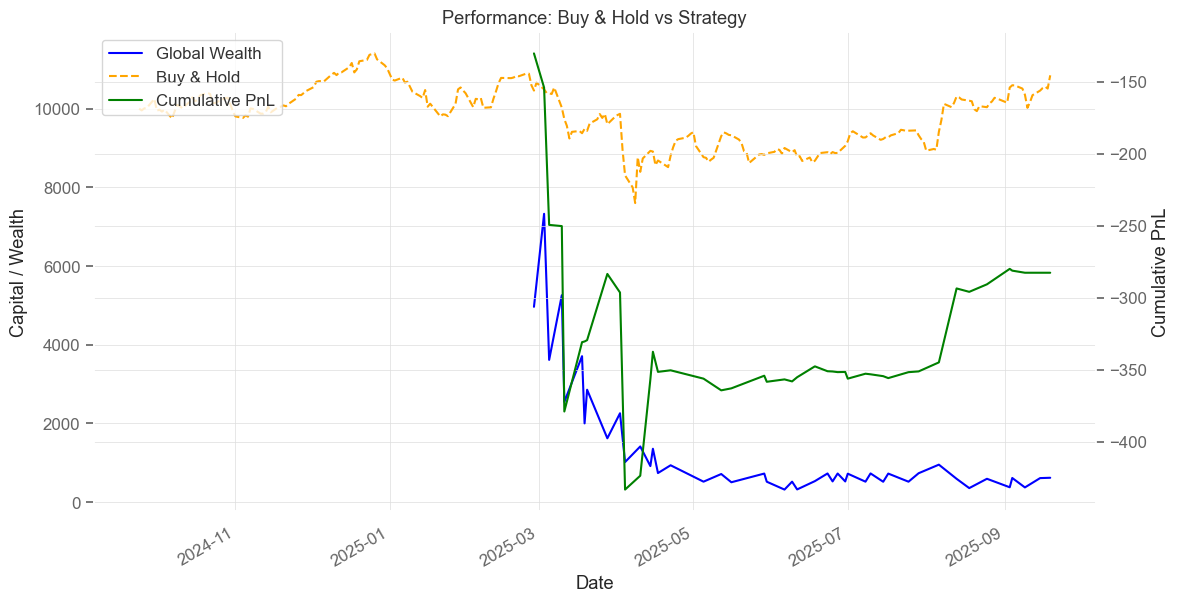

In [14]:
# === Parameters ===
ticker = "AAPL"
end_date = dt.date(2025, 9, 22)
days_nbr = 365
interval = "1d"
initial_capital = 10000

# === Run and backtest ===
strategy = ArimaTickStrategy(
    ticker=ticker,
    end_date=end_date,
    days_nbr=days_nbr,
    interval=interval,
    amount=initial_capital,
    allow_negative_balance=True,
    arima_order=(1, 1, 0), 
    window=100,
    refit_every=5,
    long_threshold=0.0007,
    short_threshold=0.0007,
    max_position_fraction=0.5)

strategy.run_backtest()

# === Analysis and Visualisation ===
ta = TradeAnalysis(
    trade_performance=strategy.trade_performance,
    capital=initial_capital,
    cost_per_trade=0,
    slippage=0,
    price_series=strategy.data['Close'])

ta.report()
ta.plot_performance()